<a href="https://colab.research.google.com/github/iCarrrot/nn_sudoku_project/blob/master/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# End of term project for Deep Learning course, SS 2020 @ University of Wrocław
Authors:
* Piotr Gdowski
* Michał Martusewicz


## Main goal
Extend the handwritten digit-recognizing network to allow verifying sudoku's solution correctness

# Befor start: runtime -> change runtime type -> GPU

In [146]:
%pylab inline
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from tqdm.notebook import tqdm

from sklearn.neighbors import KNeighborsClassifier
import torch
import torchvision
from sklearn.decomposition import PCA


try:
    from src.net import *
    from src.preprocessing import *
    from src.util import *
    
except ModuleNotFoundError:
    import httpimport
    with httpimport.github_repo(
            'iCarrrot', 
            'nn_sudoku_project',
            module='src',
            branch='master'
    ):
        from src.net import *
        from src.preprocessing import *
        from src.util import *

from collections import namedtuple
GridInstance = namedtuple('GridInstace', 'img digits')

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


TODO

* dopisać metodę sprawdzającą czy kratka jest pusta
* improvement modelu

In [147]:
pics_path = get_pics_path()
gray_images, labels= get_gray_images(pics_path)
gray_images.shape

(101, 4160, 3120)

# Dataset

We've collected and labeled a dataset consisting of 101 sudoku grids, which we splitted into three parts after preprocessing:
* 10 grids will be our test dataset on which we'll show how the full checker works
* ca. 5000 digits will be put to the model as a training data
* the rest will serve as verification dataset





  0%|          | 0/101 [00:00<?, ?it/s]



  1%|          | 1/101 [00:01<02:08,  1.28s/it]



  2%|▏         | 2/101 [00:02<02:11,  1.33s/it]



  3%|▎         | 3/101 [00:04<02:09,  1.32s/it]



  4%|▍         | 4/101 [00:05<02:05,  1.29s/it]



  5%|▍         | 5/101 [00:06<02:05,  1.31s/it]



  6%|▌         | 6/101 [00:07<02:05,  1.32s/it]



  7%|▋         | 7/101 [00:09<02:04,  1.33s/it]



  8%|▊         | 8/101 [00:10<02:04,  1.34s/it]



  9%|▉         | 9/101 [00:11<02:01,  1.32s/it]



 10%|▉         | 10/101 [00:13<02:02,  1.34s/it]



 11%|█         | 11/101 [00:14<01:59,  1.33s/it]



 12%|█▏        | 12/101 [00:15<01:58,  1.33s/it]



 13%|█▎        | 13/101 [00:17<01:52,  1.28s/it]



 14%|█▍        | 14/101 [00:17<01:23,  1.04it/s]



 15%|█▍        | 15/101 [00:18<01:32,  1.07s/it]



 16%|█▌        | 16/101 [00:18<01:08,  1.23it/s]



 17%|█▋        | 17/101 [00:20<01:21,  1.03it/s]



 18%|█▊        | 18/101 [00:20<01:00,  1.36it/s]



 19%|█▉        | 19/101 [0

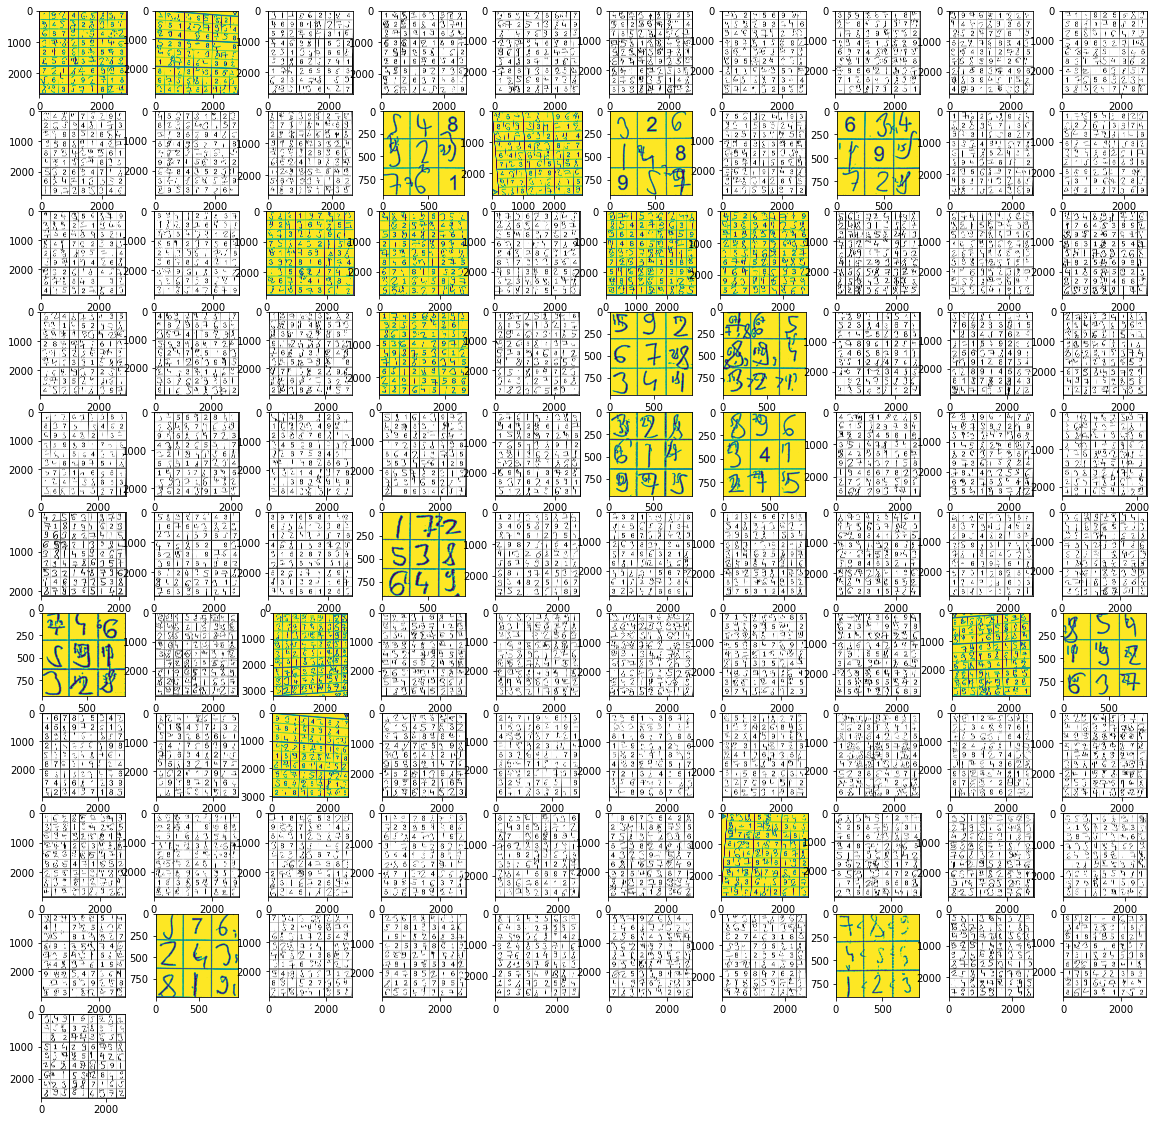

In [148]:
deskewed_imgs = []
desk_img_labels = []
plt.figure(figsize=(20, 20))
for i in tqdm(range(len(gray_images))):
    deskewed = Deskewing(gray_images[i])._deskew()
    plt.subplot(11, 10, i + 1)
    if i == 1 or not deskew_verify(deskewed):
        plt.imshow(deskewed)
    else:
        plt.imshow(deskewed, cmap='gray')
        deskewed_imgs.append(deskewed)
        desk_img_labels.append(labels[i])

6 [[3 9 7 6 5 1 8 2 4]
 [1 4 6 2 8 9 3 5 7]
 [8 5 2 4 7 3 6 1 9]
 [5 2 0 7 6 8 9 4 3]
 [9 6 4 3 1 2 7 8 5]
 [7 3 8 5 9 4 2 6 1]
 [2 1 5 8 3 7 4 9 6]
 [6 8 3 9 4 5 1 7 2]
 [4 7 9 1 2 6 5 3 8]]


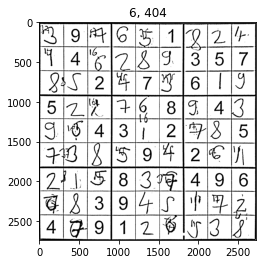

9 [[4 5 6 7 8 1 9 2 3]
 [8 2 9 6 4 3 1 5 7]
 [7 1 3 5 2 9 4 8 6]
 [5 6 4 9 3 2 7 1 8]
 [4 3 2 8 7 4 6 0 5]
 [9 8 7 1 5 6 3 4 2]
 [6 7 8 4 9 5 2 3 1]
 [3 4 1 2 6 8 5 7 9]
 [2 9 5 3 1 7 8 6 4]]


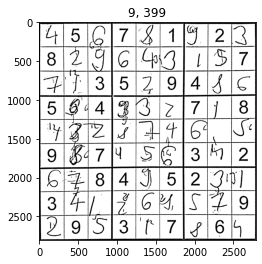

10 [[8 4 5 3 9 5 2 7 6]
 [3 7 1 0 8 0 4 5 9]
 [2 9 6 7 4 6 3 1 8]
 [9 1 8 6 7 3 5 2 4]
 [7 3 4 5 2 8 9 6 1]
 [6 5 2 4 1 9 8 3 7]
 [1 2 9 8 5 7 6 4 3]
 [5 6 7 9 3 4 1 8 2]
 [4 8 3 0 6 0 7 9 5]]


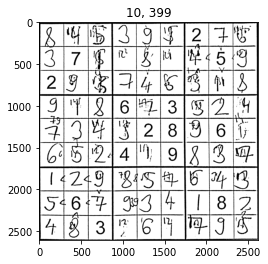

12 [[1 7 6 2 3 8 9 5 4]
 [5 2 8 9 4 7 1 3 6]
 [9 4 3 1 6 5 8 2 7]
 [3 5 2 4 9 1 6 7 8]
 [6 1 4 8 5 2 4 9 2]
 [8 9 4 3 7 6 5 1 2]
 [2 3 5 6 8 9 7 4 1]
 [4 6 9 7 1 3 2 8 5]
 [7 8 1 5 2 4 3 6 9]]


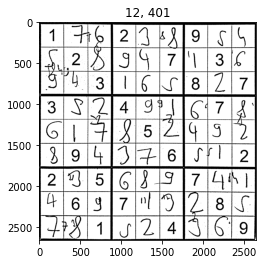

13 [[1 7 6 5 4 9 8 2 3]
 [5 2 8 6 1 3 9 7 4]
 [9 4 3 7 2 8 1 5 6]
 [6 8 7 4 9 1 5 3 2]
 [3 9 4 8 5 2 6 1 7]
 [2 1 5 3 7 6 8 9 8]
 [8 6 9 2 3 5 7 4 1]
 [7 3 1 9 6 4 2 8 5]
 [4 5 2 1 8 7 3 6 9]]


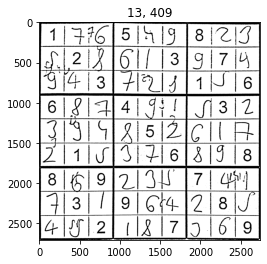

17 [[5 6 3 7 2 4 1 9 8]
 [2 4 8 3 1 9 5 6 7]
 [9 7 1 0 5 0 2 4 3]
 [7 3 2 0 4 0 9 5 1]
 [6 8 9 1 7 5 4 3 2]
 [4 1 5 2 9 3 7 8 6]
 [1 9 6 5 8 7 3 2 4]
 [8 5 4 4 3 2 1 7 9]
 [3 2 7 9 6 1 8 7 5]]


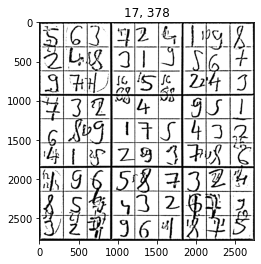

24 [[7 8 9 3 1 6 5 4 2]
 [5 2 3 8 4 9 6 7 1]
 [6 1 4 7 5 2 3 8 9]
 [3 7 8 9 6 1 2 5 4]
 [2 4 6 5 8 7 9 1 3]
 [9 5 1 2 8 4 7 6 8]
 [8 6 7 1 2 3 4 9 5]
 [1 9 2 4 7 5 8 3 6]
 [4 3 5 6 9 8 1 2 7]]


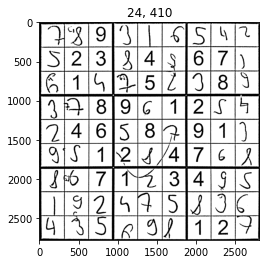

29 [[4 5 7 9 1 8 2 3 0]
 [1 6 8 2 3 4 9 5 0]
 [2 3 9 5 7 6 8 1 4]
 [3 4 5 6 9 1 7 9 2]
 [8 2 6 7 5 3 4 9 1]
 [9 7 1 4 8 2 5 6 3]
 [6 9 2 1 4 5 3 7 8]
 [5 1 3 8 2 7 6 4 9]
 [7 8 4 3 6 9 1 2 5]]


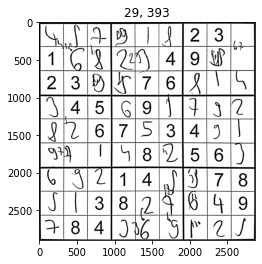

32 [[4 3 9 7 1 6 2 8 5]
 [6 1 5 8 2 9 7 3 4]
 [7 8 2 3 4 5 6 1 9]
 [3 5 1 6 7 8 9 4 2]
 [8 4 2 9 5 1 3 6 7]
 [9 2 7 4 3 2 1 5 8]
 [1 9 4 5 6 7 8 2 3]
 [2 7 3 1 8 4 5 9 6]
 [5 6 8 2 9 3 4 7 1]]


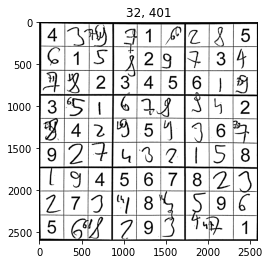

37 [[3 9 7 6 5 8 1 4 2]
 [6 5 4 1 1 2 3 8 9]
 [1 8 2 4 3 9 5 7 6]
 [4 6 8 1 9 3 7 2 5]
 [9 1 5 2 8 7 6 3 4]
 [2 7 3 5 4 6 9 1 8]
 [5 2 6 3 7 4 8 9 1]
 [8 3 1 9 2 5 4 6 7]
 [7 4 9 8 6 1 2 5 3]]


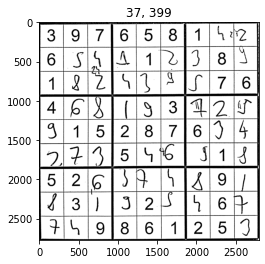

41 [[8 7 3 4 2 9 4 6 1]
 [1 4 5 6 3 7 8 2 9]
 [6 2 9 8 4 1 3 7 5]
 [7 3 4 1 9 2 6 5 8]
 [2 1 6 7 5 8 9 4 3]
 [5 9 8 4 6 3 2 1 7]
 [3 5 7 2 8 4 1 9 6]
 [4 8 1 9 7 6 5 3 2]
 [9 6 2 3 1 5 7 8 4]]


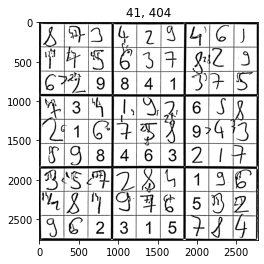

55 [[6 5 4 3 1 8 2 7 9]
 [1 3 9 7 2 6 8 4 5]
 [7 2 8 4 5 9 1 6 3]
 [8 9 3 1 4 5 7 2 6]
 [2 4 1 9 6 7 3 5 8]
 [5 7 6 2 8 3 4 9 1]
 [9 1 5 8 7 2 6 3 4]
 [3 2 7 6 9 4 5 1 2]
 [4 6 2 5 3 1 9 8 7]]


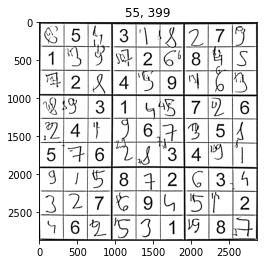

57 [[4 6 1 2 7 5 3 8 9]
 [2 5 3 4 8 9 7 6 1]
 [7 8 9 6 3 4 5 4 2]
 [3 2 4 5 6 8 1 9 7]
 [6 9 8 1 2 7 4 3 5]
 [5 1 7 9 4 3 6 2 8]
 [9 3 2 7 5 4 8 1 6]
 [8 7 6 3 1 2 9 5 4]
 [1 4 5 8 9 6 2 7 3]]


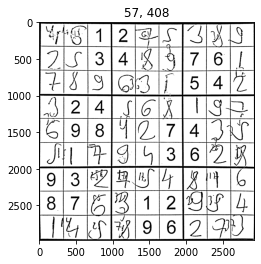

63 [[8 2 9 4 1 7 3 5 6]
 [6 4 3 5 9 8 7 1 2]
 [5 7 1 3 6 2 8 9 4]
 [7 6 2 8 3 9 5 4 1]
 [4 1 8 2 7 5 6 3 9]
 [3 9 5 6 4 1 2 8 7]
 [2 8 4 1 5 6 9 7 3]
 [0 3 6 7 8 4 1 2 5]
 [1 0 7 9 2 3 4 6 8]]


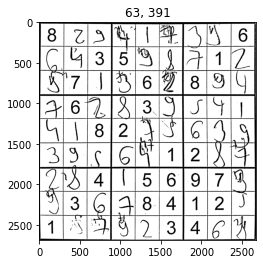

64 [[1 9 6 7 3 5 4 2 8]
 [2 3 4 1 8 6 7 9 5]
 [7 5 8 9 4 2 3 3 6]
 [5 7 9 8 2 4 6 1 3]
 [4 3 2 3 9 1 5 8 7]
 [6 8 1 6 5 7 2 4 9]
 [9 2 1 4 6 3 8 7 1]
 [8 1 3 2 7 9 3 5 4]
 [3 4 7 5 1 8 9 6 2]]


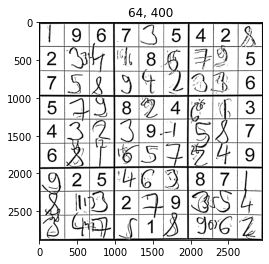

68 [[8 2 7 9 6 3 5 1 4]
 [4 1 0 7 2 5 8 3 6]
 [3 5 0 8 1 4 9 2 7]
 [6 9 1 2 5 8 7 4 3]
 [7 3 5 4 9 1 6 8 2]
 [3 4 8 3 7 6 1 9 5]
 [9 8 2 5 4 7 3 6 1]
 [1 7 4 6 3 9 2 5 8]
 [5 6 3 1 8 2 4 7 9]]


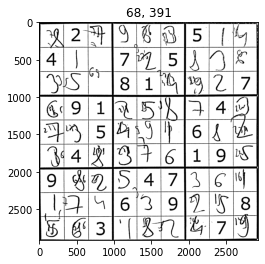

69 [[7 6 4 3 6 5 2 8 1]
 [1 5 2 4 8 9 6 7 3]
 [6 8 3 1 7 2 5 4 9]
 [9 2 8 7 5 4 1 3 6]
 [4 6 5 2 1 3 8 9 7]
 [3 1 8 6 9 8 4 2 5]
 [5 4 9 8 3 6 7 1 2]
 [8 3 1 5 2 7 9 6 4]
 [2 7 6 9 4 1 3 5 8]]


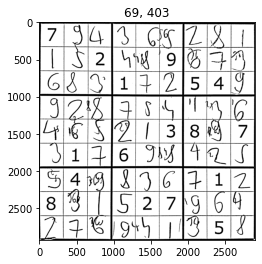

In [149]:
errors = []
for idx, (img, y) in enumerate(zip(deskewed_imgs, desk_img_labels)):
    if sum(y) != 9 * 45:
        errors.append(idx)
        print(idx, np.asarray(y).reshape(9,9))
        plt.imshow(img, cmap='gray')
        plt.title(f"{idx}, {sum(y)}")
        plt.show()

## Dataset split

In [150]:
testset_ids = np.hstack([np.random.choice(errors, 7, replace=False), [5, 40, 66]])

testset, trainset = [], []
for i in range(len(desk_img_labels)):
    if i in testset_ids:
        testset.append(GridInstance(img=deskewed_imgs[i], digits=np.asarray(desk_img_labels[i])))
    else:
        trainset.append(GridInstance(img=deskewed_imgs[i], digits=np.asarray(desk_img_labels[i])))

print(sorted(testset_ids))

[5, 6, 12, 40, 41, 55, 63, 66, 68, 69]


(5427, 28, 28)

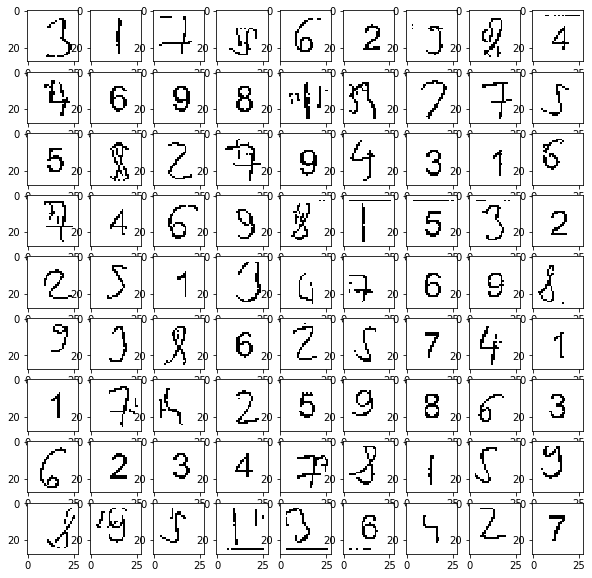

In [88]:
digits_labels = np.hstack([g.digits for g in trainset])
digits = np.vstack([split_into_cells(g.img) for g in trainset])
plt.figure(figsize=(10,10))
for i in range(81):
    plt.subplot(9, 9, i + 1)
    plt.imshow(digits[i, :, :], cmap='gray', interpolation='none')

np.savez('digits.npz',digits=digits, digits_labels=digits_labels)    
digits.shape

In [ ]:
with open('digits.npz', 'rb') as f:
    npzfile = np.load(f)
    digits = npzfile['digits']
    digits_labels = npzfile['digits_labels']

In [59]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 81
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('files/', train=True, download=True,
        transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])), 
    batch_size=batch_size_train, 
    shuffle=True)

grid_test_loader, grid_train_loader = get_test_and_train_dataloader(
    digits, 
    digits_labels, 
    batch_size_test = batch_size_test, 
    device='cuda')

## MNIST Dataset - sample digits and T-SNE decomposition

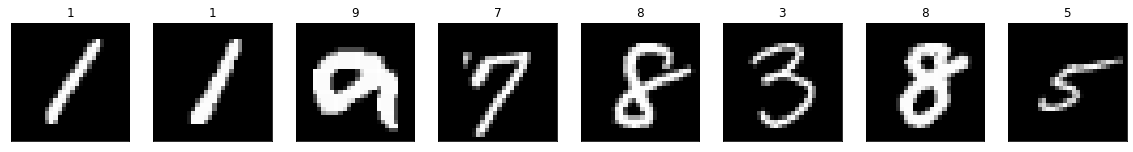

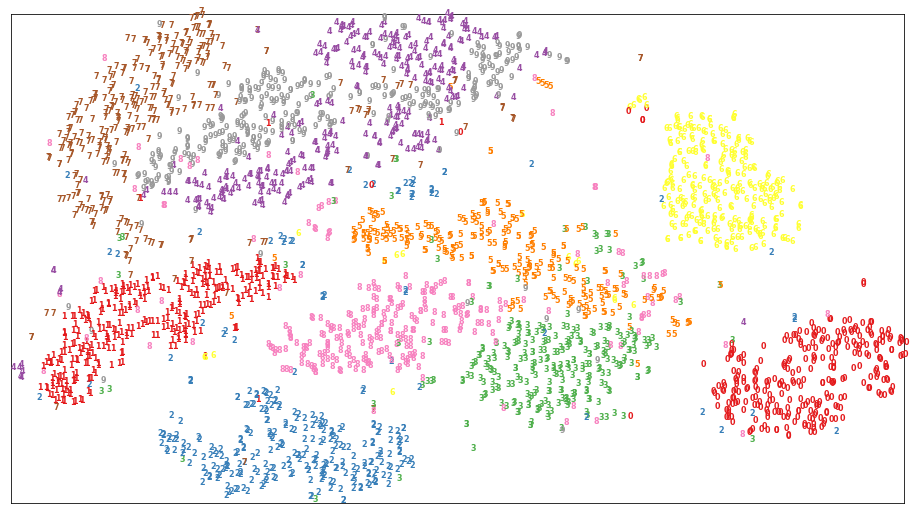

In [ ]:
present_dataset(train_loader)

## Digits from sudoku grids - sample digits and T-SNE decomposition





0it [00:00, ?it/s]



119it [00:00, 432.64it/s]


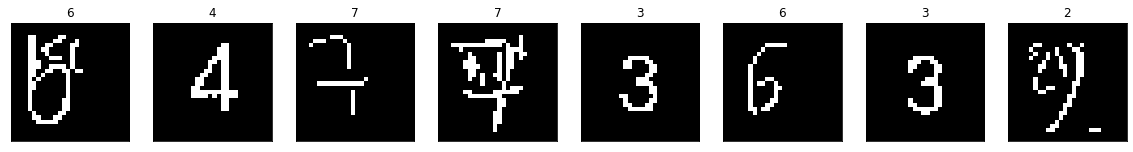

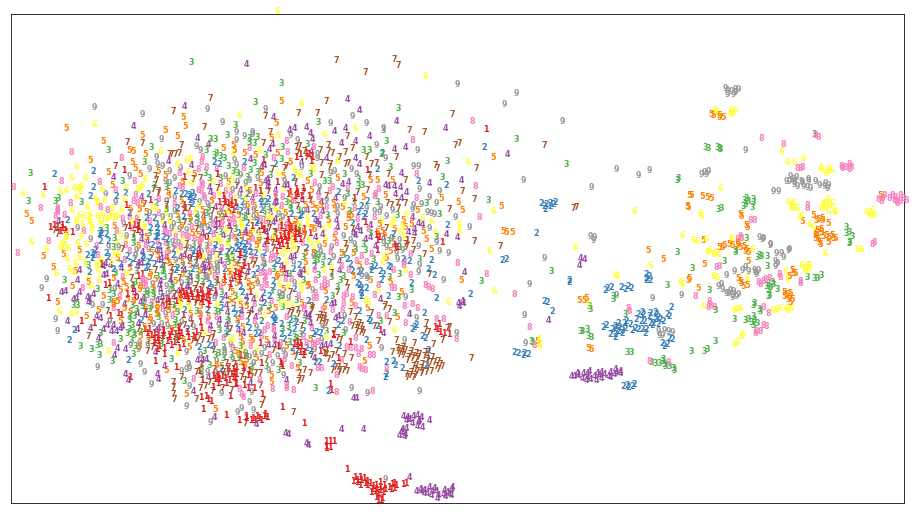

In [39]:
present_dataset(grid_train_loader)

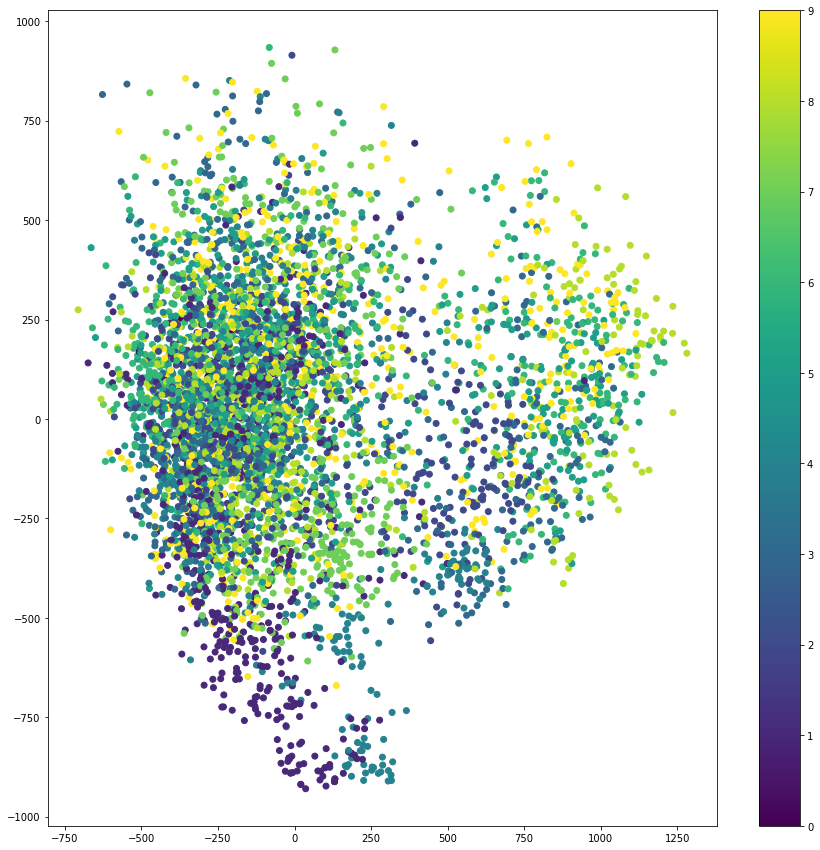

In [40]:
pca = PCA(n_components=2)
X = pca.fit_transform(digits.reshape(-1, 28*28))
X.shape
plt.figure(figsize=(15,15))
plt.scatter(X[:,0], X[:,1], c=digits_labels)
plt.colorbar()

# Classification

In this section we'll compare several approaches on classifying sudoku grids' digits.

## KNN

### 1: train on MNIST, test on sudoku_test

In [ ]:
X, y = get_pure_data(train_loader)
clf = KNeighborsClassifier()
clf.fit(X, y)

X_test, y_test = get_pure_data(grid_test_loader)

clf.score(X_test, y_test)

0.248388696083292

### 2: train on sudoku_train, test on sudoku_test

In [ ]:
X, y = get_pure_data(grid_train_loader)
clf = KNeighborsClassifier()
clf.fit(X, y)

X_test, y_test = get_pure_data(grid_test_loader)

clf.score(X_test, y_test)

0.46554288547347544

### 3: train on PCA(sudoku_train), test on PCA(sudoku_test)

In [ ]:
X, y = get_pure_data(grid_train_loader)
X_test, y_test = get_pure_data(grid_test_loader)

for n_components in [10, 20, 30, 35, 40, 45, 50, 70, 100, 200]:
    pca = PCA(n_components=n_components)
    pca.fit(X)
    
    pca_train = pca.transform(X)
    pca_test = pca.transform(X_test)
    
    clf = KNeighborsClassifier()
    clf.fit(pca_train, y)

    print(f"{n_components} components: {clf.score(pca_test, y_test)}")


10 components: 0.6450173525037184
20 components: 0.7248388696083292
30 components: 0.7327714427367378
39 components: 0.7263262270699058
40 components: 0.7377293009419931
41 components: 0.7317798710956867
42 components: 0.7327714427367378
45 components: 0.7273177987109569
50 components: 0.7268220128904314
70 components: 0.7045116509667824
100 components: 0.6608824987605354
200 components: 0.5547843331680714


## NN

### Approach 1: Simple NN on different datasets

In [ ]:
model = Net()
model.to('cuda')
train(model=model, device='cuda', train_loader=train_loader, title="Train on mnist dataset", optimizer=torch.optim.Adam(model.parameters()))
prediction = test(model=model, device='cuda', test_loader=grid_test_loader)

Train Epoch: Train on mnist dataset [0/60000 (0%)]	Loss: 2.309647
Train Epoch: Train on mnist dataset [6400/60000 (11%)]	Loss: 0.200662
Train Epoch: Train on mnist dataset [12800/60000 (21%)]	Loss: 0.067301
Train Epoch: Train on mnist dataset [19200/60000 (32%)]	Loss: 0.264715
Train Epoch: Train on mnist dataset [25600/60000 (43%)]	Loss: 0.068207
Train Epoch: Train on mnist dataset [32000/60000 (53%)]	Loss: 0.132696
Train Epoch: Train on mnist dataset [38400/60000 (64%)]	Loss: 0.083295
Train Epoch: Train on mnist dataset [44800/60000 (75%)]	Loss: 0.069763
Train Epoch: Train on mnist dataset [51200/60000 (85%)]	Loss: 0.152600
Train Epoch: Train on mnist dataset [57600/60000 (96%)]	Loss: 0.074948

Test set: Average loss: 125.8736, Accuracy: 1133/2017 (56%)



In [ ]:
model = Net()
model.to('cuda')
train(model=model, device='cuda', train_loader=grid_train_loader, title="Train on own dataset", optimizer=torch.optim.Adam(model.parameters()))
prediction = test(model=model, device='cuda', test_loader=grid_test_loader)

Train Epoch: Train on own dataset [0/4706 (0%)]	Loss: 14.738880

Test set: Average loss: 0.9195, Accuracy: 1526/2017 (76%)



### Approach 2: Simple NN on different datasets

In [ ]:
model = ExperimentalNet()
model.to('cuda')
train(model=model, device='cuda', train_loader=train_loader, epoch=5, title="Train on mnist dataset", optimizer=torch.optim.Adam(model.parameters()))
prediction = test(model=model, device='cuda', test_loader=grid_test_loader)

Train on mnist dataset
Train, Epoch: 0/5 [0/60000 (0%)]	Loss: 2.320347
Train, Epoch: 0/5 [6400/60000 (11%)]	Loss: 0.190906
Train, Epoch: 0/5 [12800/60000 (21%)]	Loss: 0.403593
Train, Epoch: 0/5 [19200/60000 (32%)]	Loss: 0.279992
Train, Epoch: 0/5 [25600/60000 (43%)]	Loss: 0.150659
Train, Epoch: 0/5 [32000/60000 (53%)]	Loss: 0.089815
Train, Epoch: 0/5 [38400/60000 (64%)]	Loss: 0.358146
Train, Epoch: 0/5 [44800/60000 (75%)]	Loss: 0.091605
Train, Epoch: 0/5 [51200/60000 (85%)]	Loss: 0.100084
Train, Epoch: 0/5 [57600/60000 (96%)]	Loss: 0.103182
Train, Epoch: 1/5 [0/60000 (0%)]	Loss: 0.094396
Train, Epoch: 1/5 [6400/60000 (11%)]	Loss: 0.110771
Train, Epoch: 1/5 [12800/60000 (21%)]	Loss: 0.102738
Train, Epoch: 1/5 [19200/60000 (32%)]	Loss: 0.056727
Train, Epoch: 1/5 [25600/60000 (43%)]	Loss: 0.104366
Train, Epoch: 1/5 [32000/60000 (53%)]	Loss: 0.081427
Train, Epoch: 1/5 [38400/60000 (64%)]	Loss: 0.111188
Train, Epoch: 1/5 [44800/60000 (75%)]	Loss: 0.154293
Train, Epoch: 1/5 [51200/60000 (85%

In [41]:
model = ExperimentalNet()
model.to('cuda')
train(model=model, device='cuda', train_loader=grid_train_loader, epoch=30, title="Train on own dataset", optimizer=torch.optim.Adam(model.parameters()))
prediction = test(model=model, device='cuda', test_loader=grid_test_loader)

Train on own dataset
Train, Epoch: 1/30 [0/3798 (0%)]	Loss: 8.993759
Train, Epoch: 1/30 [3200/3798 (84%)]	Loss: 1.567642
Train, Epoch: 2/30 [0/3798 (0%)]	Loss: 1.156593
Train, Epoch: 2/30 [3200/3798 (84%)]	Loss: 1.064545
Train, Epoch: 3/30 [0/3798 (0%)]	Loss: 0.459568
Train, Epoch: 3/30 [3200/3798 (84%)]	Loss: 0.790993
Train, Epoch: 4/30 [0/3798 (0%)]	Loss: 0.528314
Train, Epoch: 4/30 [3200/3798 (84%)]	Loss: 0.517728
Train, Epoch: 5/30 [0/3798 (0%)]	Loss: 0.330076
Train, Epoch: 5/30 [3200/3798 (84%)]	Loss: 0.407620
Train, Epoch: 6/30 [0/3798 (0%)]	Loss: 0.362935
Train, Epoch: 6/30 [3200/3798 (84%)]	Loss: 0.569653
Train, Epoch: 7/30 [0/3798 (0%)]	Loss: 0.745934
Train, Epoch: 7/30 [3200/3798 (84%)]	Loss: 0.399086
Train, Epoch: 8/30 [0/3798 (0%)]	Loss: 0.187925
Train, Epoch: 8/30 [3200/3798 (84%)]	Loss: 0.205527
Train, Epoch: 9/30 [0/3798 (0%)]	Loss: 0.193748
Train, Epoch: 9/30 [3200/3798 (84%)]	Loss: 0.161645
Train, Epoch: 10/30 [0/3798 (0%)]	Loss: 0.161626
Train, Epoch: 10/30 [3200/3798

## Saving model

In [42]:
torch.save(model.state_dict(), '/random_net.xyz')

In [ ]:
restored_model = ExperimentalNet()
restored_model.load_state_dict(torch.load('/random_net.xyz'))

In [ ]:
prediction = test(model=model, device='cuda', test_loader=grid_test_loader)

# Real life application

Given a sudoku grid, find errors or say it's fine

In [ ]:
len(testset)

In [ ]:
img, y = testset[5]
print(y.reshape(9,9), sum(y))
plt.imshow(img, cmap='gray')

In [ ]:
def detect_empty_cell(cell):
    pass


def get_predictions(model, device, dataloader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

    return pred
            # print(pred.reshape((9,9)))
            # correct += pred.eq(target.view_as(pred)).sum().item()

grid_cells = split_into_cells(img)
nonempty_cells = []
for idx, cell in enumerate(grid_cells):
    if detect_empty_cell(cell):
        pass
        # mark on grid
    else:
        nonempty_cells.append(idx)

grid_dataloader = get_dataloader(grid_cells[nonempty_cells], y[nonempty_cells])

predicted = get_predictions(restored_model, 'cpu', grid_dataloader).numpy().reshape((9,9))

In [ ]:
print(predicted)
cell_width = img.shape[0] // 9
cells_with_errors = {}
for i, j in itertools.product(range(9), range(9)):
    for k in range(9):
        if predicted[i, j] == predicted[i, k] and k > j:
            cells_with_errors[((i,j), (i,k))] = 1

        if predicted[j, i] == predicted[k, i] and k > j:
            cells_with_errors[((j,i), (k,i))] = 1

    for k, l in itertools.product(range(3), range(3)):
        ci, cj = 3 * (i // 3) + k, 3 * (j // 3) + l
        if predicted[i, j] == predicted[ci, cj] and (i % 3 > k or (i % 3 == k and j % 3 > l)):
            cells_with_errors[(i,j), (ci, cj)] = 1


rgb_img = cv2.cvtColor(img ,cv2.COLOR_GRAY2RGB)
for (j1, i1), (j2, i2) in cells_with_errors.keys():  # indeksy celowo swapnięte
    color = (np.random.choice(255), np.random.choice(255), np.random.choice(255))
    rgb_img = cv2.rectangle(rgb_img, 
                (i1 * cell_width, j1 * cell_width), 
                ((i1+1) * cell_width, (j1+1) * cell_width),
                color,
                50)
    rgb_img = cv2.rectangle(rgb_img, 
                (i2 * cell_width, j2 * cell_width), 
                ((i2+1) * cell_width, (j2+1) * cell_width),
                color,
                50)
    
    print(f"Value of cell {(j1, i1)}: {predicted[j1, i1]} excludes value {predicted[j2, i2]} in {(j2, i2)}")

plt.imshow(rgb_img)
if len(cells_with_errors) == 0:
    print('This grid has no errors!')

# Not my sandbox
[PyTorch MNIST](https://github.com/pytorch/examples/blob/master/mnist/main.py)

In [ ]:
model = ExperimentalNet()
model.to('cuda')
train(model=model, device='cuda', train_loader=grid_train_loader, epoch=30, title="Train on own dataset", optimizer=torch.optim.Adam(model.parameters()))

prediction = test(model=model, device='cuda', test_loader=grid_test_loader)

In [ ]:
model = ExperimentalNet()
model.to('cuda')
train(model=model, device='cuda', train_loader=train_loader, epoch=1, title="Train on mnist dataset", optimizer=torch.optim.Adam(model.parameters()))
train(model=model, device='cuda', train_loader=grid_train_loader, epoch=23, title="Train on own dataset", optimizer=torch.optim.Adam(model.parameters()))

prediction = test(model=model, device='cuda', test_loader=grid_test_loader)

In [43]:
model = ExperimentalNet()
model.to('cuda')
train(model=model, device='cuda', train_loader=train_loader, epoch=1, title="Train on mnist dataset", optimizer=torch.optim.Adam(model.parameters()))
train(model=model, device='cuda', train_loader=grid_train_loader, epoch=23, title="Train on own dataset", optimizer=torch.optim.Adam(model.parameters()))

prediction = test(model=model, device='cuda', test_loader=grid_test_loader)

<All keys matched successfully>

In [44]:
prediction = test(model=model, device='cuda', test_loader=grid_test_loader)


Test set: Average loss: 0.7359, Accuracy: 1425/1629 (87%)



# Real life application

Given a sudoku grid, find errors or say it's fine

In [151]:
len(testset)

10

[[6 5 4 3 1 8 2 7 9]
 [1 3 9 7 2 6 8 4 5]
 [7 2 8 4 5 9 1 6 3]
 [8 9 3 1 4 5 7 2 6]
 [2 4 1 9 6 7 3 5 8]
 [5 7 6 2 8 3 4 9 1]
 [9 1 5 8 7 2 6 3 4]
 [3 2 7 6 9 4 5 1 2]
 [4 6 2 5 3 1 9 8 7]] 399


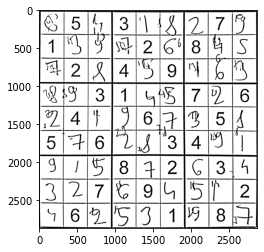

In [160]:
img, y = testset[5]
print(y.reshape(9,9), sum(y))
plt.imshow(img, cmap='gray')

In [161]:
def detect_empty_cell(cell):
    pass


def get_predictions(model, device, dataloader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

    return pred
            # print(pred.reshape((9,9)))
            # correct += pred.eq(target.view_as(pred)).sum().item()

grid_cells = split_into_cells(img)
nonempty_cells = []
for idx, cell in enumerate(grid_cells):
    if detect_empty_cell(cell):
        pass
        # mark on grid
    else:
        nonempty_cells.append(idx)

grid_dataloader = get_dataloader(grid_cells[nonempty_cells], y[nonempty_cells])

predicted = get_predictions(restored_model, 'cpu', grid_dataloader).numpy().reshape((9,9))

[[6 5 4 3 1 8 2 7 1]
 [1 3 9 7 2 6 8 4 5]
 [7 2 8 4 3 9 1 6 3]
 [2 9 3 1 4 6 7 2 6]
 [2 4 1 9 6 7 3 5 8]
 [5 7 6 2 8 3 4 9 1]
 [9 1 5 8 7 2 6 3 4]
 [3 2 7 6 9 4 5 1 2]
 [4 6 2 5 3 1 2 8 7]]
Value of cell (3, 0): 2 excludes value 2 in (4, 0)
Value of cell (0, 4): 1 excludes value 1 in (0, 8)
Value of cell (2, 1): 2 excludes value 2 in (7, 1)
Value of cell (2, 4): 3 excludes value 3 in (2, 8)
Value of cell (2, 4): 3 excludes value 3 in (0, 3)
Value of cell (2, 6): 1 excludes value 1 in (0, 8)
Value of cell (3, 0): 2 excludes value 2 in (3, 7)
Value of cell (3, 5): 6 excludes value 6 in (3, 8)
Value of cell (4, 0): 2 excludes value 2 in (3, 0)
Value of cell (2, 4): 3 excludes value 3 in (8, 4)
Value of cell (4, 4): 6 excludes value 6 in (3, 5)
Value of cell (1, 5): 6 excludes value 6 in (3, 5)
Value of cell (0, 6): 2 excludes value 2 in (8, 6)
Value of cell (7, 1): 2 excludes value 2 in (7, 8)
Value of cell (0, 8): 1 excludes value 1 in (5, 8)
Value of cell (8, 2): 2 excludes value 2 in (

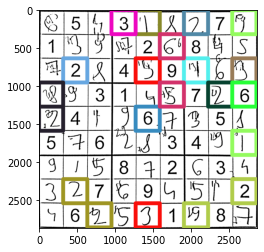

In [162]:
print(predicted)
cell_width = img.shape[0] // 9
cells_with_errors = {}
for i, j in itertools.product(range(9), range(9)):
    for k in range(9):
        if predicted[i, j] == predicted[i, k] and k > j:
            cells_with_errors[((i,j), (i,k))] = 1

        if predicted[j, i] == predicted[k, i] and k > j:
            cells_with_errors[((j,i), (k,i))] = 1

    for k, l in itertools.product(range(3), range(3)):
        ci, cj = 3 * (i // 3) + k, 3 * (j // 3) + l
        if predicted[i, j] == predicted[ci, cj] and (i % 3 > k or (i % 3 == k and j % 3 > l)):
            cells_with_errors[(i,j), (ci, cj)] = 1


rgb_img = cv2.cvtColor(img ,cv2.COLOR_GRAY2RGB)
for (j1, i1), (j2, i2) in cells_with_errors.keys():  # indeksy celowo swapnięte
    color = (np.random.choice(255), np.random.choice(255), np.random.choice(255))
    rgb_img = cv2.rectangle(rgb_img, 
                (i1 * cell_width, j1 * cell_width), 
                ((i1+1) * cell_width, (j1+1) * cell_width),
                color,
                50)
    rgb_img = cv2.rectangle(rgb_img, 
                (i2 * cell_width, j2 * cell_width), 
                ((i2+1) * cell_width, (j2+1) * cell_width),
                color,
                50)
    
    print(f"Value of cell {(j1, i1)}: {predicted[j1, i1]} excludes value {predicted[j2, i2]} in {(j2, i2)}")

plt.imshow(rgb_img)
if len(cells_with_errors) == 0:
    print('This grid has no errors!')

# Test section

### Example NN
[PyTorch MNIST](https://github.com/pytorch/examples/blob/master/mnist/main.py)

In [ ]:
model = ExperimentalNet()
model.to('cuda')
train(model=model, device='cuda', train_loader=grid_train_loader, epoch=100, title="Train on own dataset", optimizer=torch.optim.Adam(model.parameters()))
prediction = test(model=model, device='cuda', test_loader=grid_test_loader)

Train on mnist dataset
Train, Epoch: 1/1 [0/60000 (0%)]	Loss: 2.312994
Train, Epoch: 1/1 [6400/60000 (11%)]	Loss: 0.479052
Train, Epoch: 1/1 [12800/60000 (21%)]	Loss: 0.271688
Train, Epoch: 1/1 [19200/60000 (32%)]	Loss: 0.155875
Train, Epoch: 1/1 [25600/60000 (43%)]	Loss: 0.130625
Train, Epoch: 1/1 [32000/60000 (53%)]	Loss: 0.179897
Train, Epoch: 1/1 [38400/60000 (64%)]	Loss: 0.147403
Train, Epoch: 1/1 [44800/60000 (75%)]	Loss: 0.189315
Train, Epoch: 1/1 [51200/60000 (85%)]	Loss: 0.087876
Train, Epoch: 1/1 [57600/60000 (96%)]	Loss: 0.149057
Train on own dataset
Train, Epoch: 1/23 [0/4706 (0%)]	Loss: 141.777390
Train, Epoch: 2/23 [0/4706 (0%)]	Loss: 1.693252
Train, Epoch: 3/23 [0/4706 (0%)]	Loss: 1.324156
Train, Epoch: 4/23 [0/4706 (0%)]	Loss: 0.988420
Train, Epoch: 5/23 [0/4706 (0%)]	Loss: 1.407893
Train, Epoch: 6/23 [0/4706 (0%)]	Loss: 0.454623
Train, Epoch: 7/23 [0/4706 (0%)]	Loss: 0.623635
Train, Epoch: 8/23 [0/4706 (0%)]	Loss: 0.696565
Train, Epoch: 9/23 [0/4706 (0%)]	Loss: 0.56662

In [ ]:
model = ExperimentalNet()
model.to('cuda')
train(model=model, device='cuda', train_loader=grid_train_loader, epoch=500, title="Train on own dataset", optimizer=torch.optim.Adam(model.parameters()), test_loader=grid_test_loader)
prediction = test(model=model, device='cuda', test_loader=grid_test_loader)